In [1]:
# import libraries
import pandas as pd
import numpy as np
import scipy as stats
import plotly as py
import plotly.graph_objs as go
from plotly import subplots
from plotly import tools
import scipy.optimize
from scipy.optimize import OptimizeWarning
import warnings
import math
import matplotlib.pyplot as plt
from  sklearn.linear_model import LinearRegression
from matplotlib.dates import date2num
from datetime import datetime

In [2]:
# load dataframe
from google.colab import files
data = files.upload()

Saving EURUSDHour.csv to EURUSDHour.csv


In [3]:
# (1) load up our data & create moving average
df = pd.read_csv('EURUSDHour.csv')
df.columns = ['date','open','high','low','close','volume']
df.date = pd.to_datetime(df.date, format='%d.%m.%Y %H:%M:%S.%f')
df = df.set_index(df.date)
df = df[['open','high','low','close','volume']]
df = df.drop_duplicates(keep=False)
train = df.iloc[:100]
test = df.iloc[1500:3000]

ma = train.close.rolling(center=False, window=30).mean()

In [4]:
# Plot candlesticks
fig = go.Figure(data=[go.Candlestick(x=train.index, open=train.open, high=train.high, low=train.low, close=train.close, name='Currency Quote')])
trace = go.Scatter(x=train.index, y=ma, mode='lines', name='30MA')
fig.add_trace(trace)

In [5]:
# holder
class holder:
  1

In [6]:
# Heiken Ashi Candles
def heikenashi(prices, periods):
  """"
  :param prices: dataframe of OHLC & volume data
  :param periods: periods for which to create the candles
  :return: Heiken Ashi OHLC candles
  """

  results = holder()

  dict = {}

  HAclose = prices[['open','high','close','low']].sum(axis=1)/4
  HAopen = HAclose.copy()
  HAopen.iloc[0] = HAclose.iloc[0]
  HAhigh = HAclose.copy()
  HAlow = HAclose.copy()

  for i in range (1, len(prices)):
    HAopen.iloc[i] = (HAopen.iloc[i-1]+HAclose.iloc[i-1])/2
    HAhigh.iloc[i] = np.array([prices.high.iloc[i], HAopen.iloc[i], HAclose.iloc[i]]).max()
    HAlow.iloc[i] = np.array([prices.low.iloc[i], HAopen.iloc[i], HAclose.iloc[i]]).min()

  df2 = pd.concat((HAopen, HAhigh, HAlow, HAclose), axis=1)
  df2.columns = ['open','high','close','low']

  #df2.index = df2.index.droplevel(0)

  dict[periods[0]] = df2

  results.candles = dict

  return results

In [7]:
# (2) Get function data from Heiken Ashi function:
HAresults = heikenashi(train, [1])
HA = HAresults.candles[1]

In [8]:
# (3) Plot Heiken Ashi Candles
fig2 = go.Figure(data=[go.Candlestick(x=HA.index, open=HA.open, high=HA.high, low=HA.low, close=HA.close, name='Heiken Ashi')])
fig2.show()

In [9]:
# Data DeTrender
def detrend(prices, method='difference'):
  """
  :param prices: dataframe of OHLC & volume data
  :param method: method by which to detrend 'linear' or 'difference'
  :return: the detrended price series
  """
  if method == 'difference':
    detrended = prices.close[1:]-prices.close[:-1].values

  elif method == 'linear':
    x = np.arange(0, len(prices))
    y = prices.close.values
    model = LinearRegression()
    model.fit(x.reshape(-1,1),y.reshape(-1,1))
    trend = model.predict(x.reshape(-1,1))
    trend = trend.reshape((len(prices),))

    detrended = prices.close - trend

  else:
    print('You did not input a valid method for detrending! Options are linear or difference')

  return detrended

In [10]:
# (4) Get function data from detrend(linear) function:
detrended = detrend(train,method='linear')

In [11]:
# (5) Plot detrender(linear)
trace0 = go.Ohlc(x=train.index, open=train.open, high=train.high, low=train.low, close=train.close, name='Currency Quote')
trace1 = go.Scatter(x=train.index, y=ma, mode='lines', name='30MA')
trace2 = go.Scatter(x=train.index, y=detrended, mode='lines', name='Detrended')

data = [trace, trace1, trace2]

fig3 = py.subplots.make_subplots(rows=2, cols=1, shared_xaxes=True, shared_yaxes=True)
fig3.append_trace(trace0,1,1)
fig3.append_trace(trace1,1,1)
fig3.append_trace(trace2,2,1)
fig3.show()

In [12]:
# (6) Get function data from detrend(difference) function:
detrended = detrend(train,method='difference')

In [13]:
# (7) Plot detrender(difference)
trace0 = go.Ohlc(x=train.index, open=train.open, high=train.high, low=train.low, close=train.close, name='Currency Quote')
trace1 = go.Scatter(x=train.index, y=ma, mode='lines', name='30MA')
trace2 = go.Scatter(x=train.index, y=detrended, mode='lines', name='Detrended')

data = [trace, trace1, trace2]

fig4 = py.subplots.make_subplots(rows=2, cols=1, shared_xaxes=True, shared_yaxes=True)
fig4.append_trace(trace0,1,1)
fig4.append_trace(trace1,1,1)
fig4.append_trace(trace2,2,1)
fig4.show()

In [14]:
 # Fourier Series Expansion Fitting Function
 def fseries(x,a0,a1,b1,w):
   """
   :param x: hours(independent variable)
   :param a0: first fourier series coeeficient (intercept)
   :param a1: second fourier series coeeficient 
   :param b1: third fourier series coeeficient
   :param w: fourier series frequency
   :return: the value of the fourier series
   """

   f = a0 + a1*np.cos(w*x) + b1*np.sin(w*x)

   return f

In [15]:
# Sine Series Expansion Fitting Function
def sseries(x,a0,b1,w):
   """
   :param x: hours(independent variable)
   :param a0: first sine series coeeficient (intercept)
   :param b1: second sine series coeeficient
   :param w: sine series frequency
   :return: the value of the sine series
   """

   s = a0 + b1*np.sin(w*x)

   return s

In [16]:
# Fourier Series Coeeficient Calculator Function
def fourier(prices, periods, method='difference'):
  """
  :param prices: OHLC dataframe
  :param periods: list of periods for which to compute coefficients [3, 5, 10, ...]
  :param method: method by which to detrend 'linear' or 'difference'
  :return: the dataframe containing coefficients for said periods
  """

  results = holder()
  dict = {}

  # Option to plot the expansion fit for each iteration
  plot = True

  # Compute the coeeficients of the series
  detrended = detrend(prices, method)

  for i in range(0, len(periods)):
    coeffs = []
    for j in range(periods[i], len(prices)-periods[i]):
      x = np.arange(0, periods[i])
      y = detrended.iloc[j-periods[i]:j]

      with warnings.catch_warnings():
        warnings.simplefilter('error', OptimizeWarning)

        try:
          res = scipy.optimize.curve_fit(fseries,x,y)
        except (RuntimeError, OptimizeWarning):
          res = np.empty((1,4))
          res[0,:] = np.NAN
      if plot == True:
          xt = np.linspace(0,periods[i],100)
          yt = fseries(xt,res[0][0],res[0][1],res[0][2],res[0][3])

          plt.plot(x,y)
          plt.plot(xt,yt,'r')

          plt.show()

      coeffs = np.append(coeffs,res[0],axis=0)

    warnings.filterwarnings('ignore',category=np.VisibleDeprecationWarning)

    coeffs = np.array(coeffs).reshape(((len(coeffs)//4,4)))

    df = pd.DataFrame(coeffs, index=prices.iloc[periods[i]:-periods[i]].index)

    df.columns = [['a0','a1','b1','w']]

    df = df.fillna(method='bfill')

    dict[periods[i]] = df

  results.coeefs = dict

  return results

In [17]:
# Sine Series Coeeficient Calculator Function
def sine(prices, periods, method='difference'):
  """
  :param prices: OHLC dataframe
  :param periods: list of periods for which to compute coefficients [3, 5, 10, ...]
  :param method: method by which to detrend 'linear' or 'difference'
  :return: the dataframe containing coefficients for said periods
  """

  results = holder()
  dict = {}

  # Option to plot the expansion fit for each iteration
  plot = True

  # Compute the coeeficients of the series
  detrended = detrend(prices, method)

  for i in range(0, len(periods)):
    coeffs = []
    for j in range(periods[i], len(prices)-periods[i]):
      x = np.arange(0, periods[i])
      y = detrended.iloc[j-periods[i]:j]

      with warnings.catch_warnings():
        warnings.simplefilter('error', OptimizeWarning)

        try:
          res = scipy.optimize.curve_fit(sseries,x,y)
        except (RuntimeError, OptimizeWarning):
          res = np.empty((1,3))
          res[0,:] = np.NAN
      if plot == True:
          xt = np.linspace(0,periods[i],100)
          yt = sseries(xt,res[0][0],res[0][1],res[0][2])

          plt.plot(x,y)
          plt.plot(xt,yt,'r')

          plt.show()

      coeffs = np.append(coeffs,res[0],axis=0)

    warnings.filterwarnings('ignore',category=np.VisibleDeprecationWarning)

    coeffs = np.array(coeffs).reshape(((len(coeffs)//3,3)))

    df = pd.DataFrame(coeffs, index=prices.iloc[periods[i]:-periods[i]].index)

    df.columns = [['a0','b1','w']]

    df = df.fillna(method='bfill')

    dict[periods[i]] = df

  results.coeefs = dict

  return results

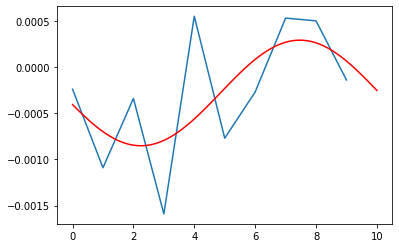

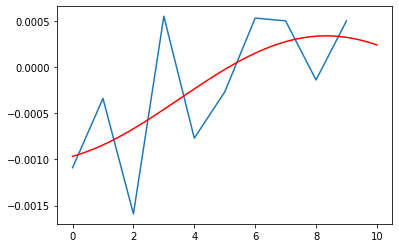

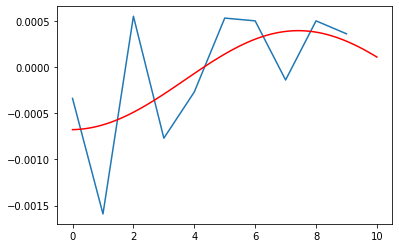

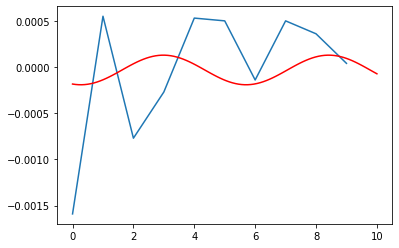

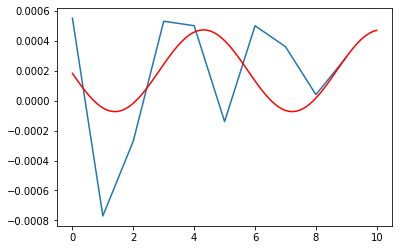

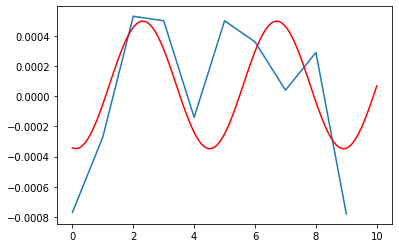

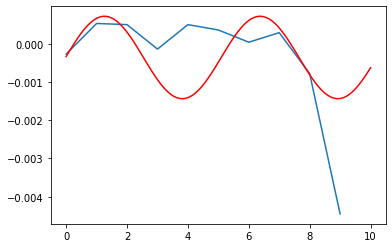

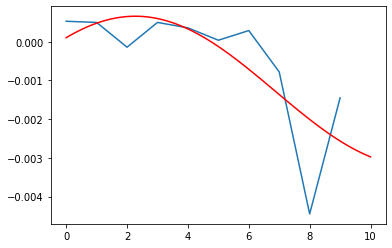

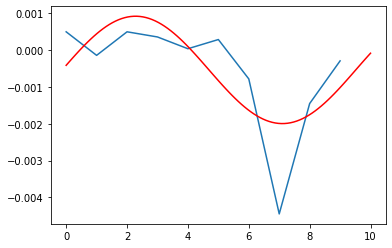

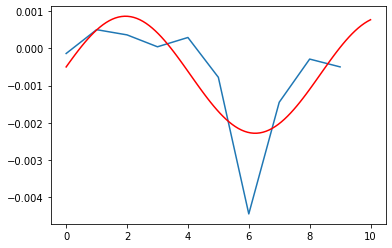

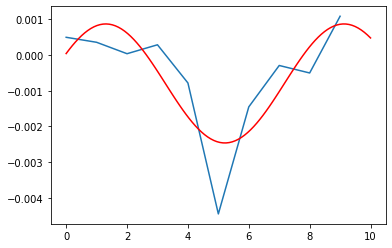

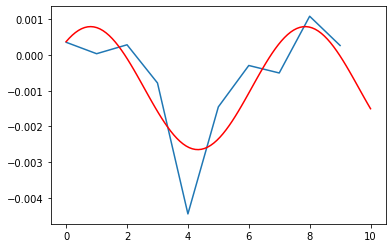

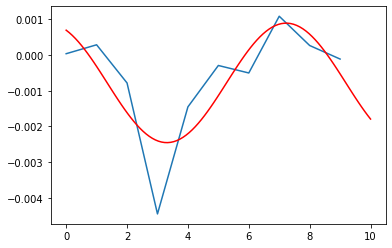

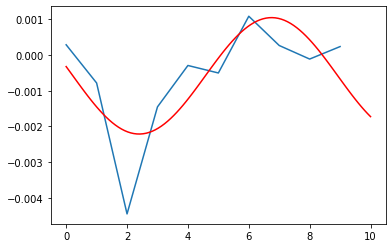

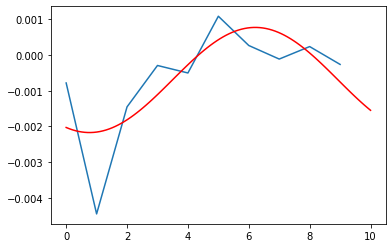

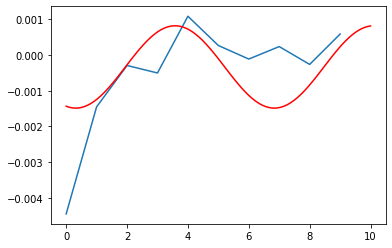

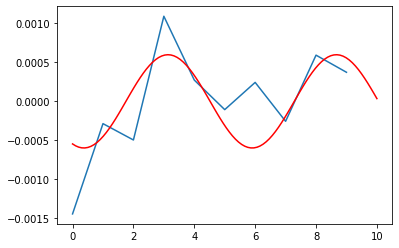

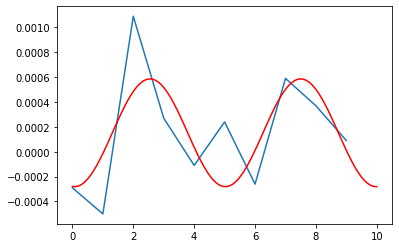

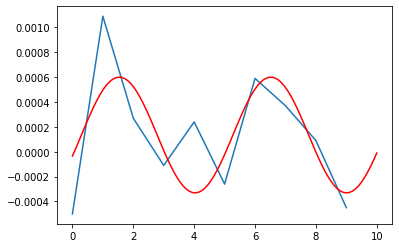

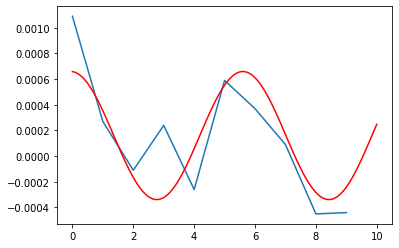

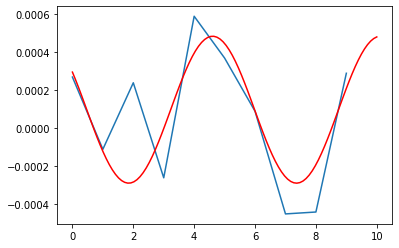

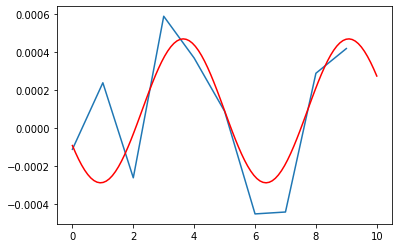

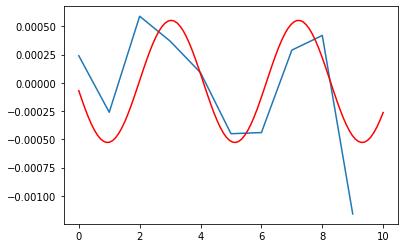

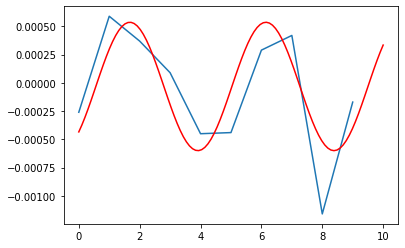

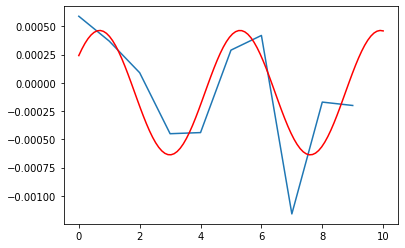

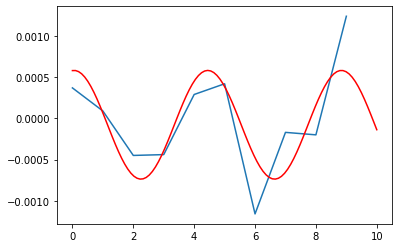

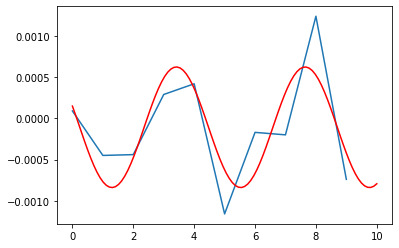

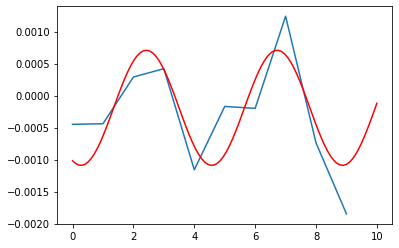

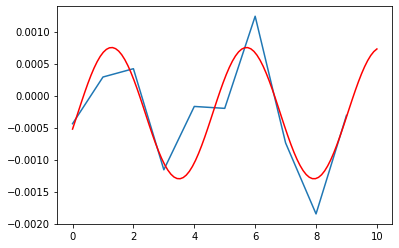

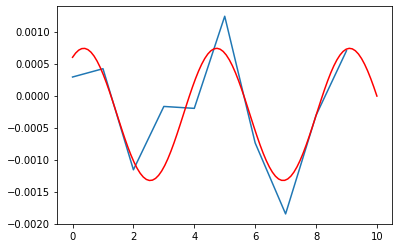

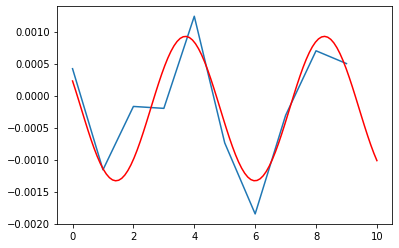

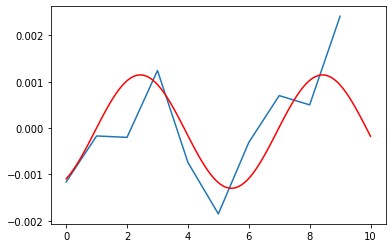

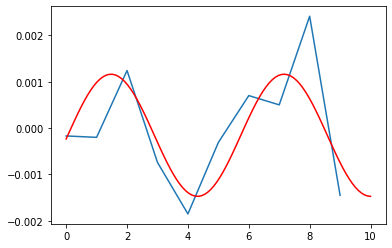

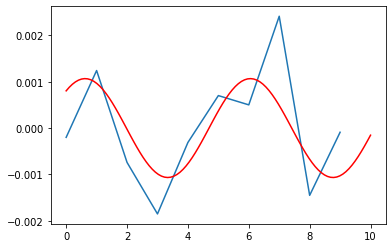

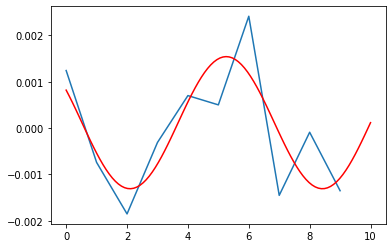

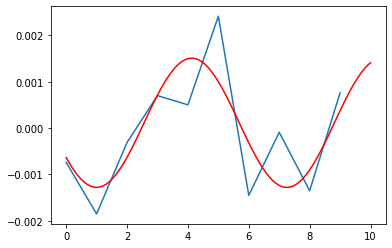

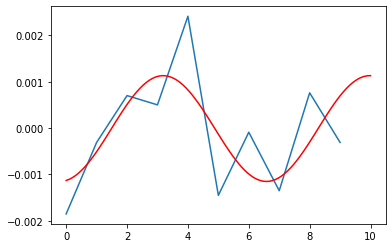

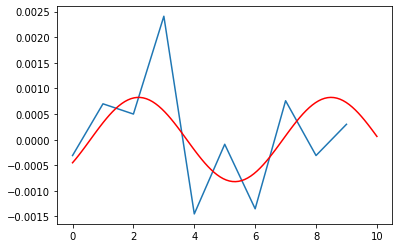

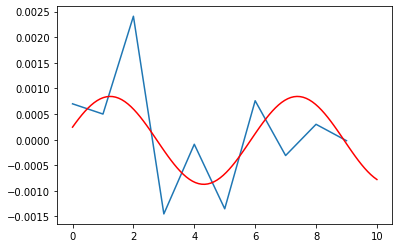

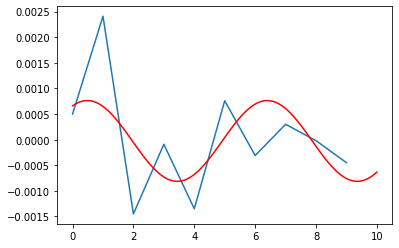

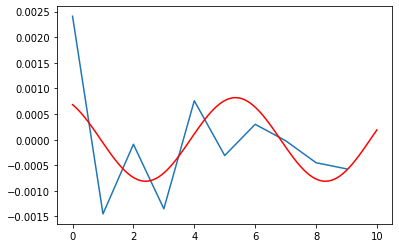

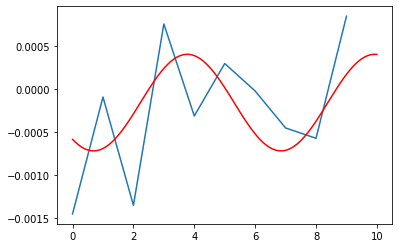

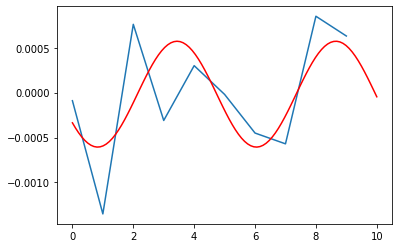

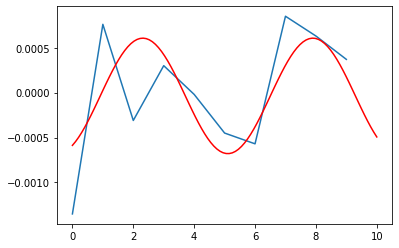

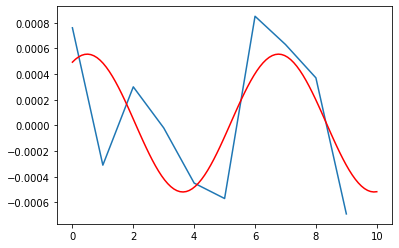

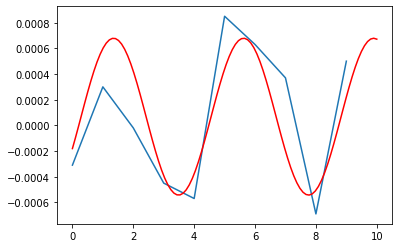

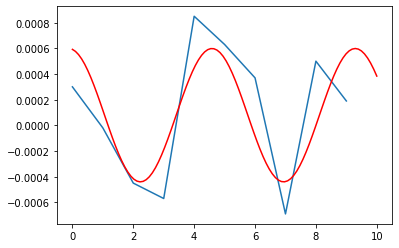

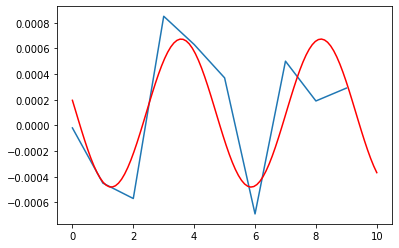

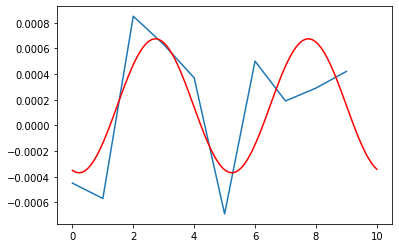

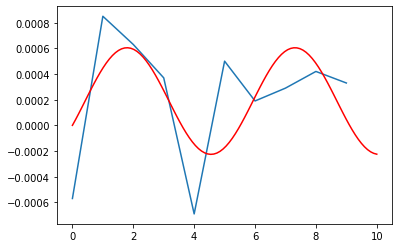

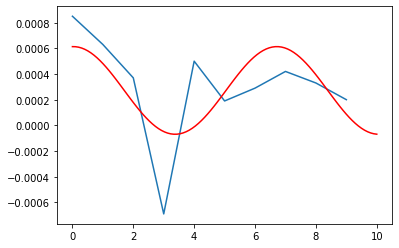

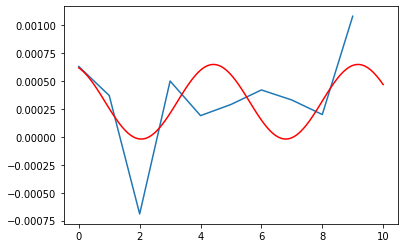

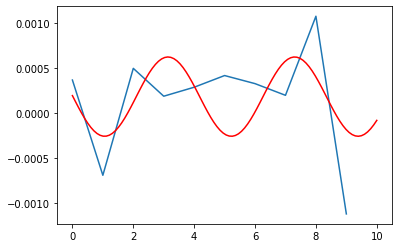

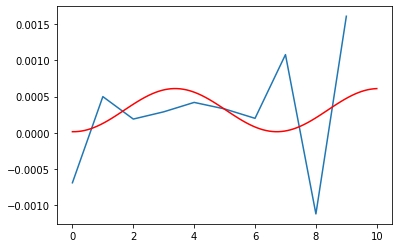

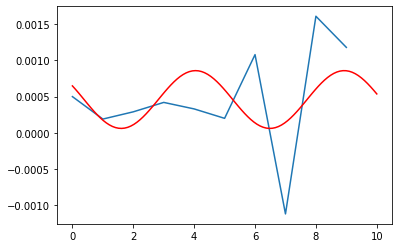

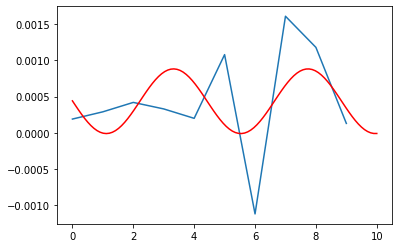

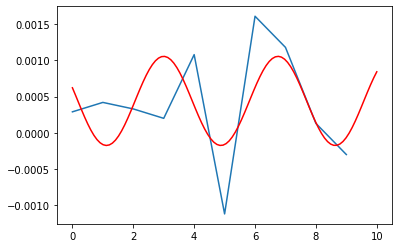

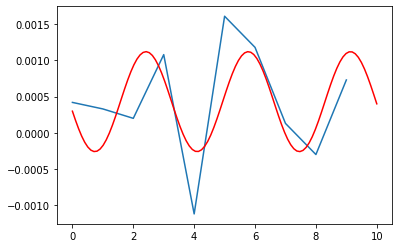

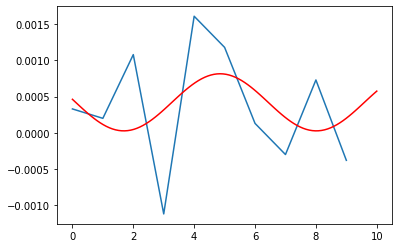

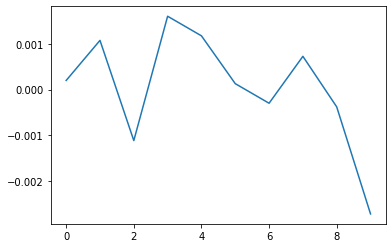

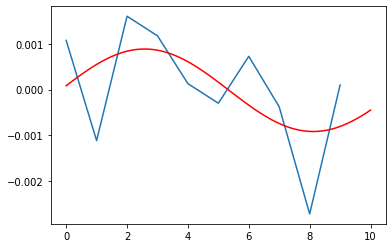

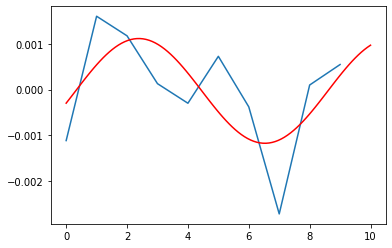

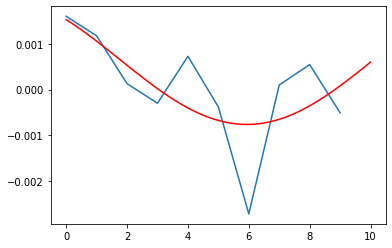

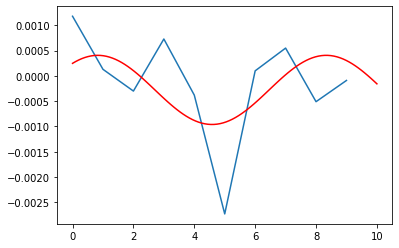

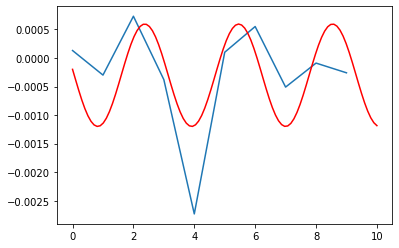

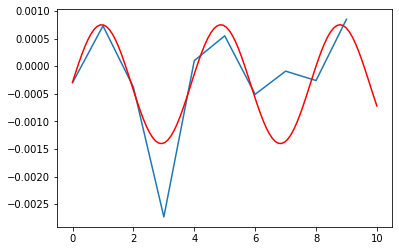

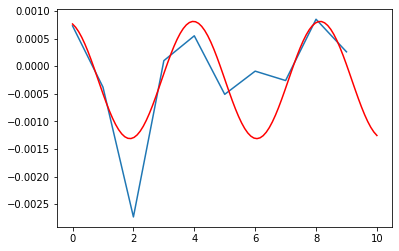

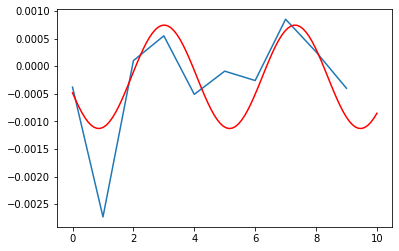

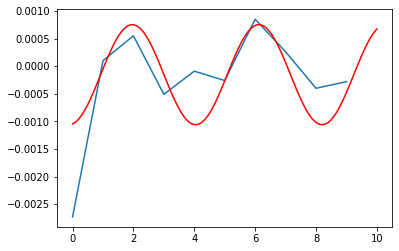

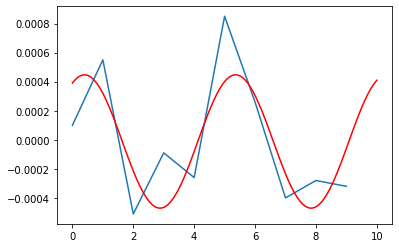

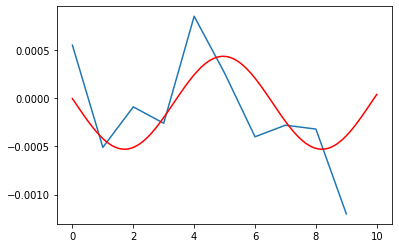

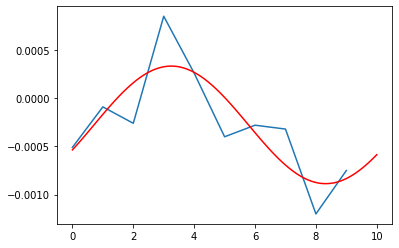

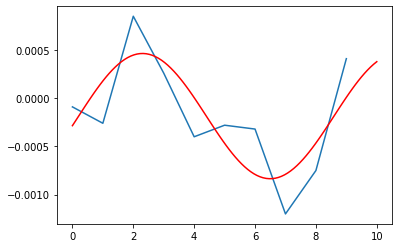

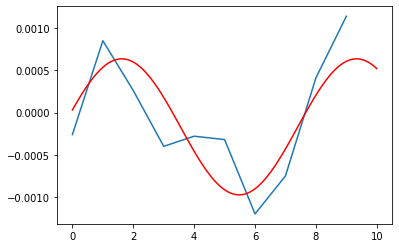

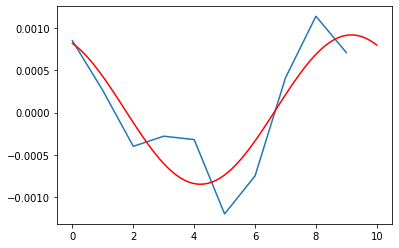

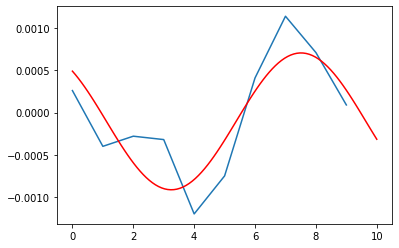

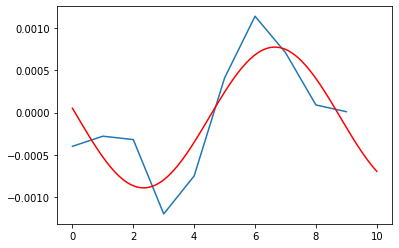

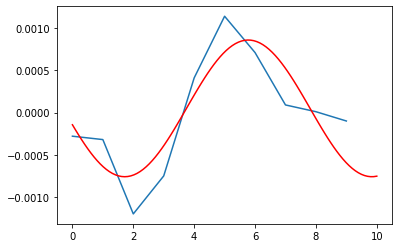

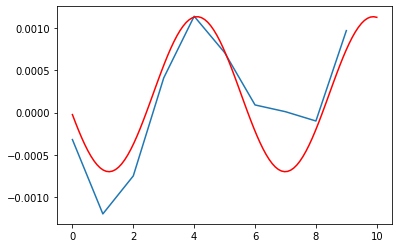

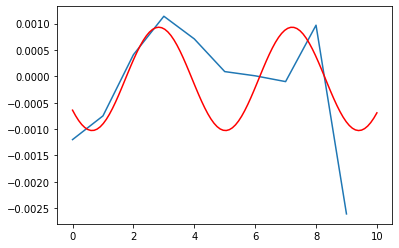

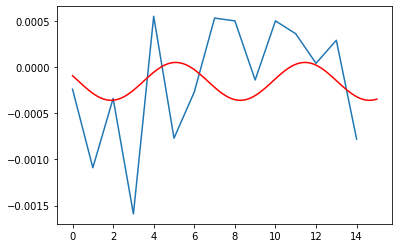

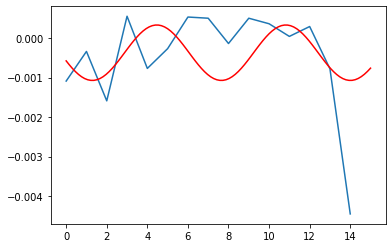

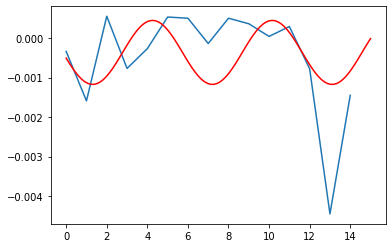

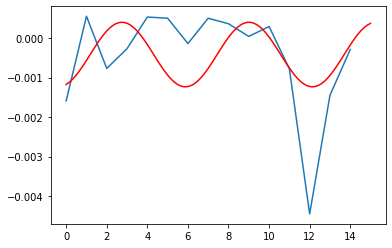

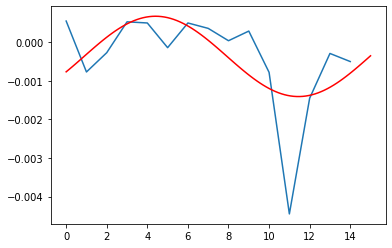

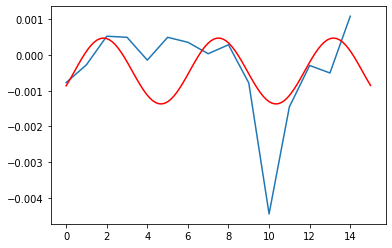

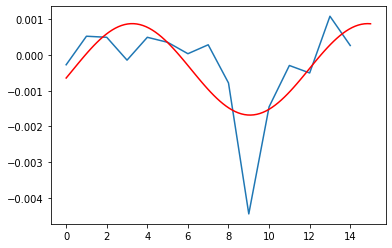

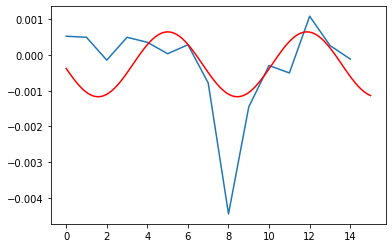

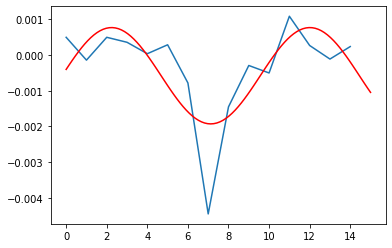

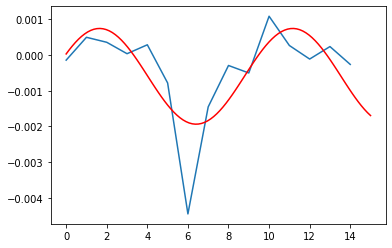

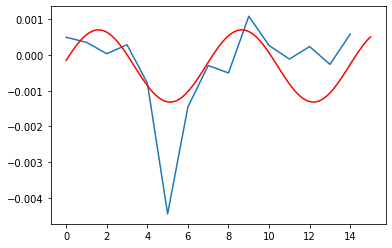

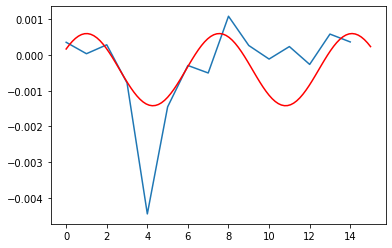

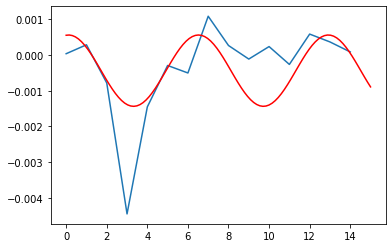

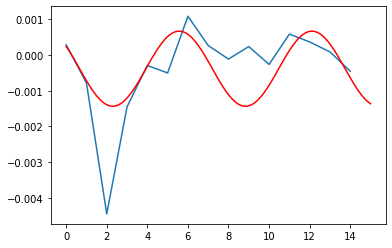

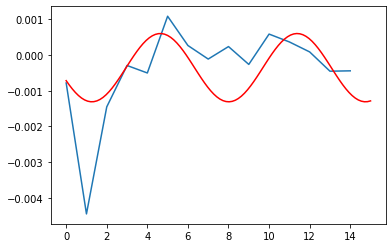

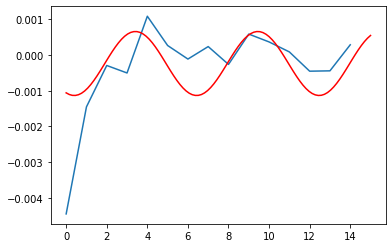

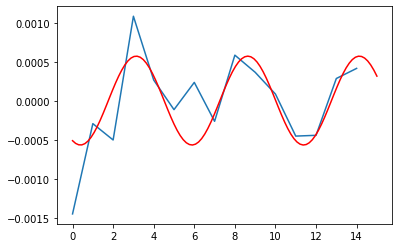

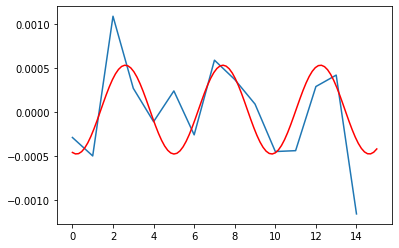

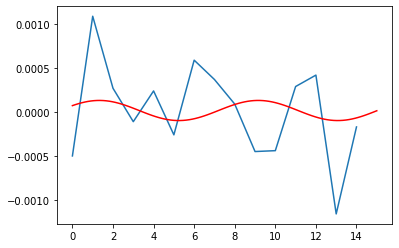

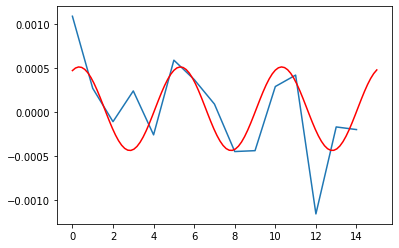

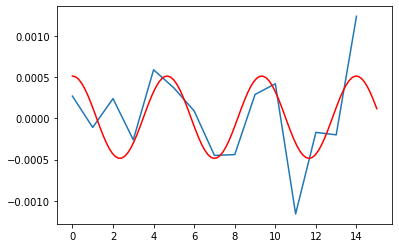

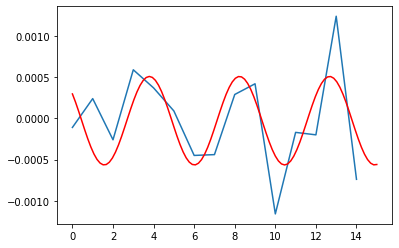

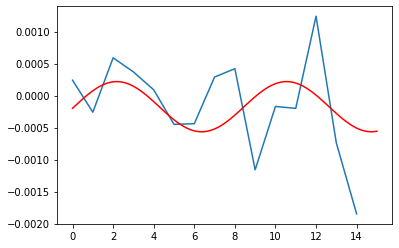

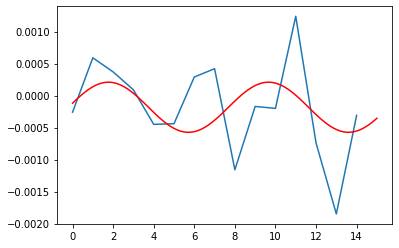

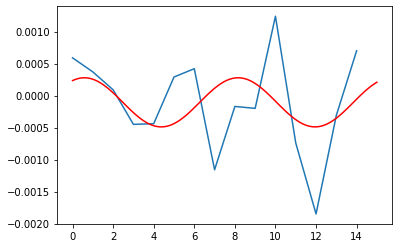

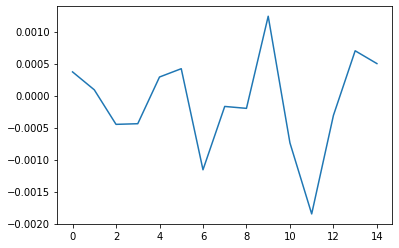

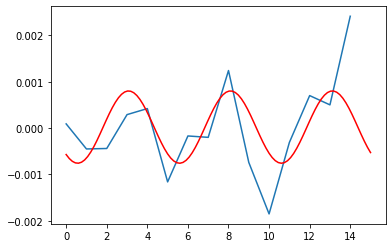

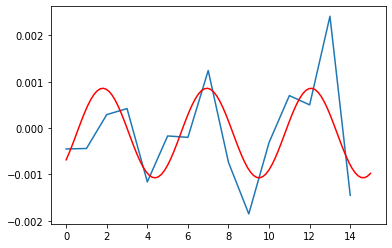

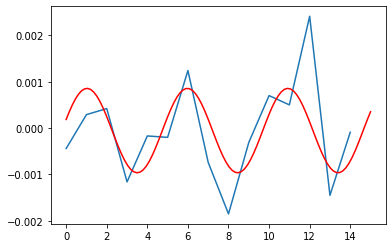

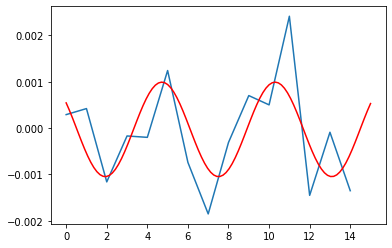

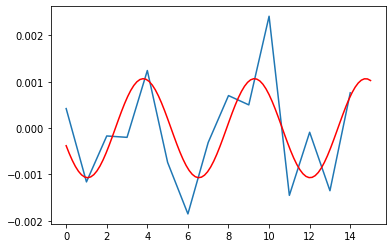

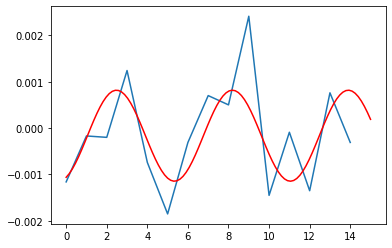

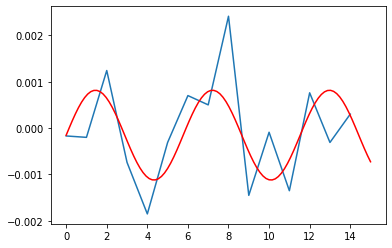

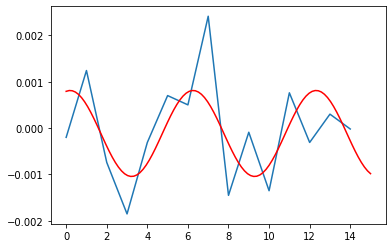

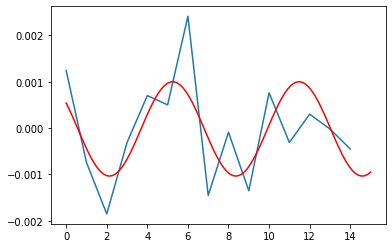

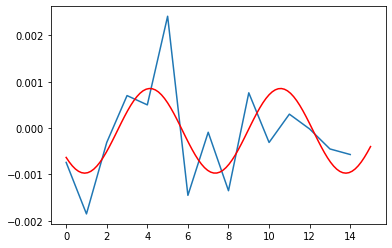

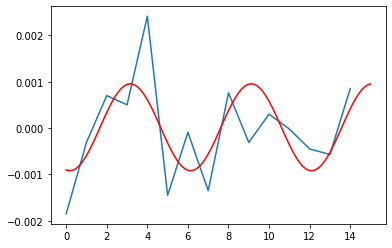

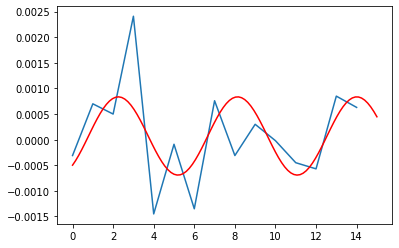

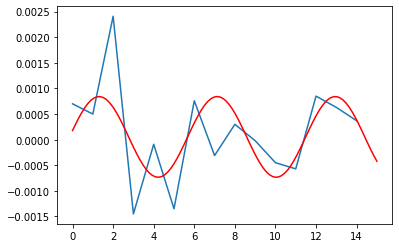

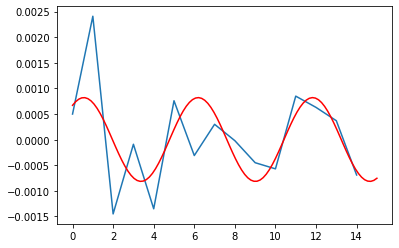

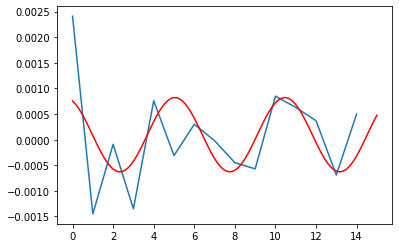

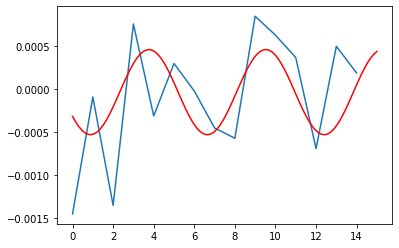

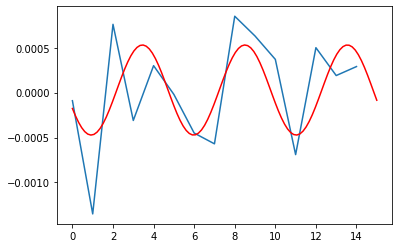

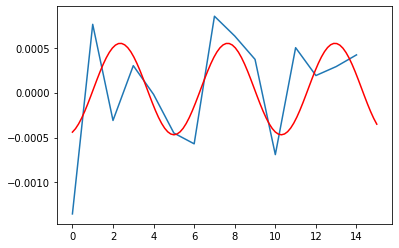

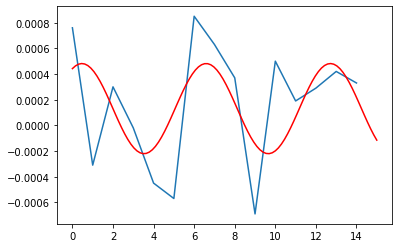

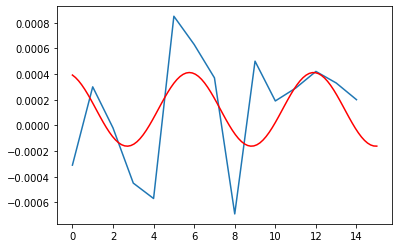

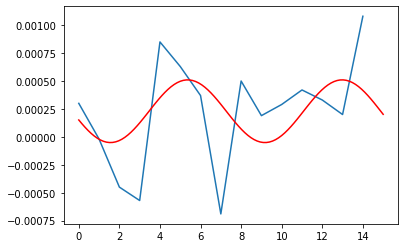

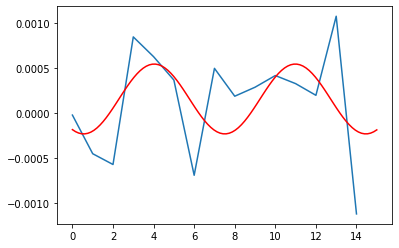

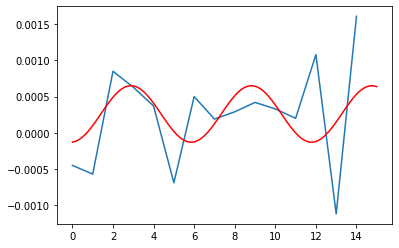

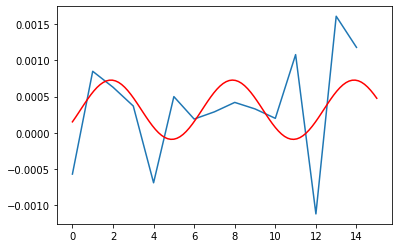

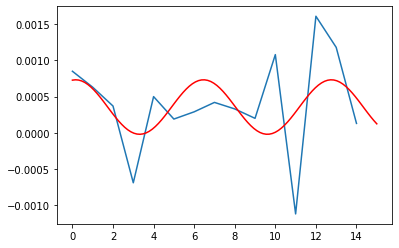

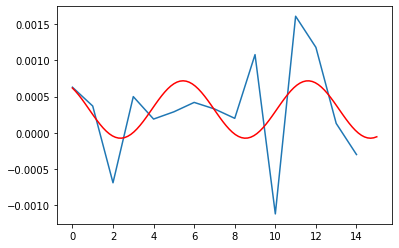

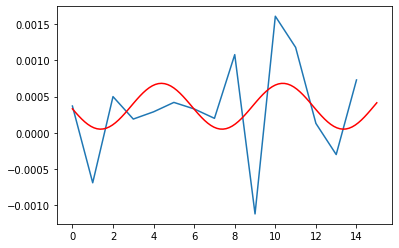

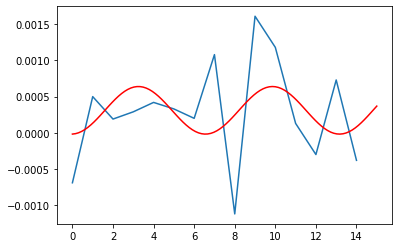

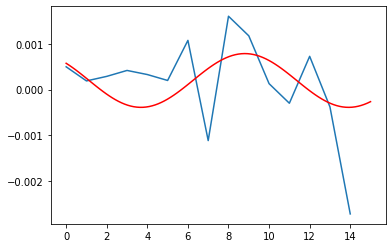

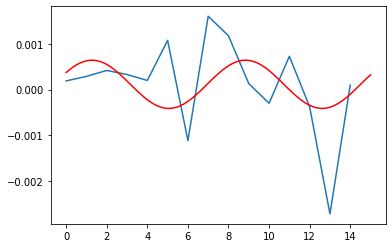

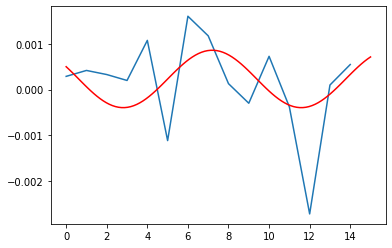

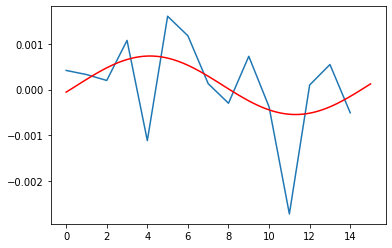

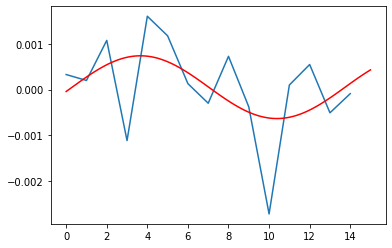

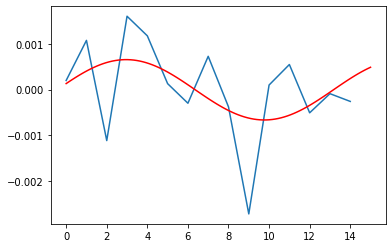

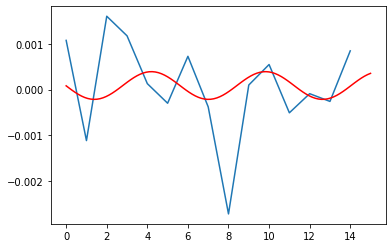

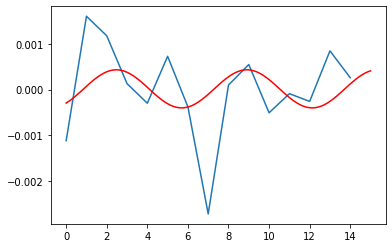

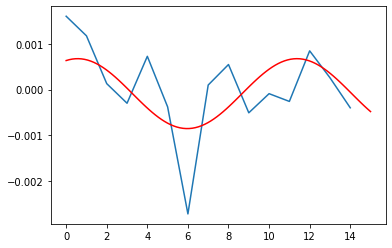

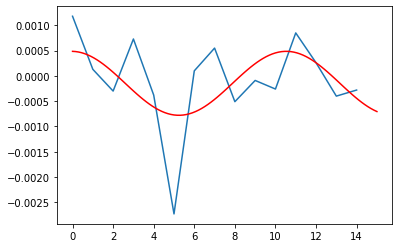

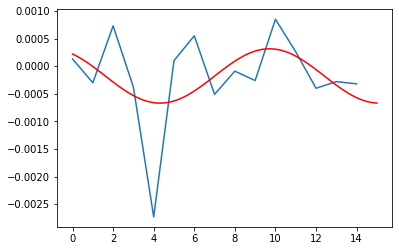

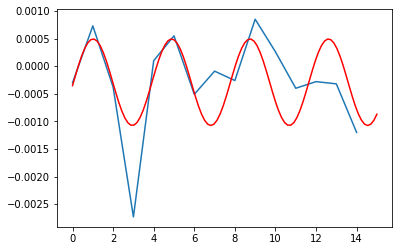

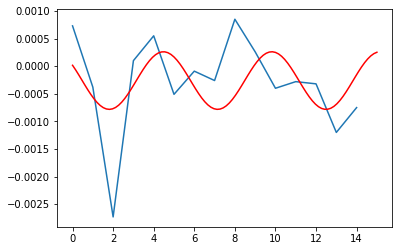

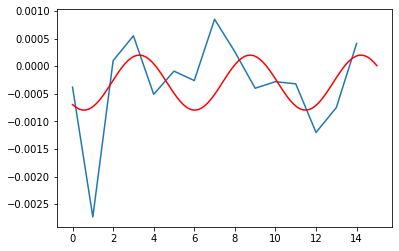

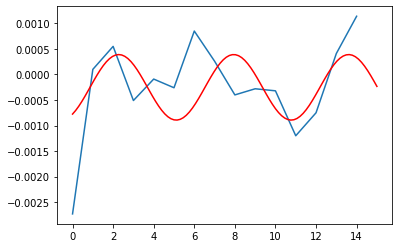

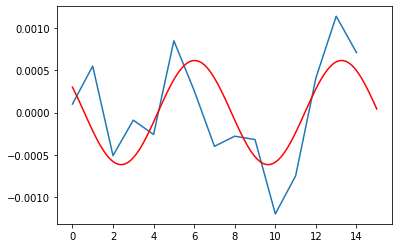

In [18]:
# (8) Get function data from fourier series function:
f = fourier(train,[10,15],method='difference')

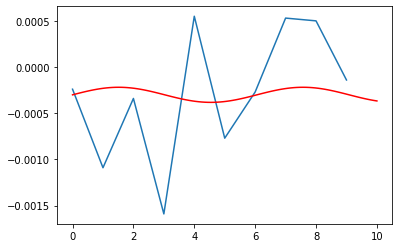

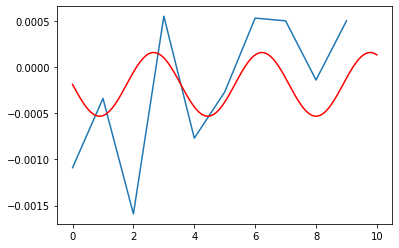

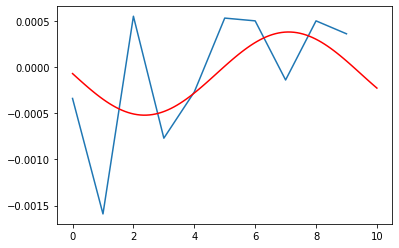

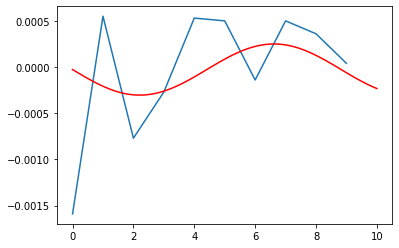

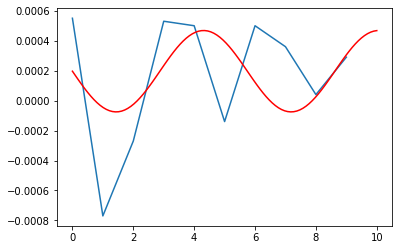

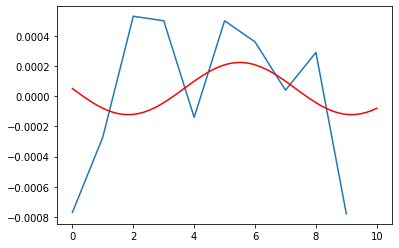

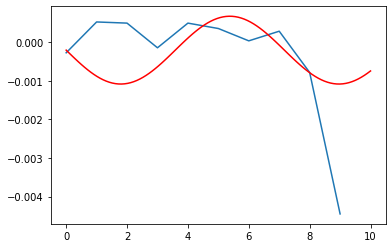

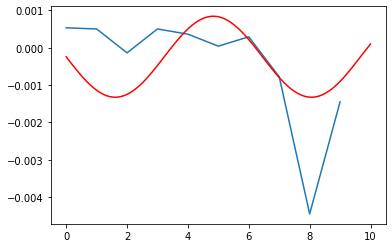

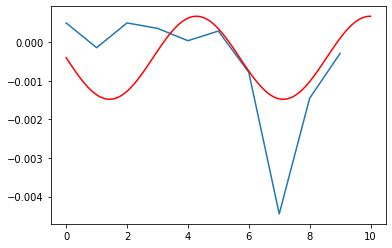

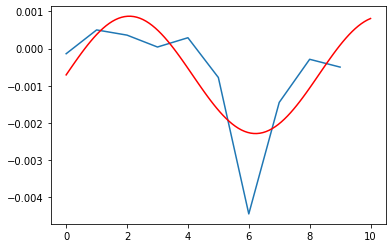

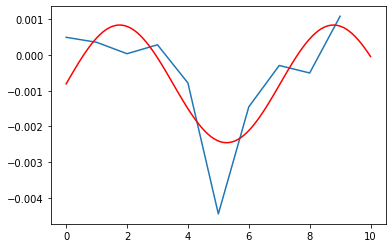

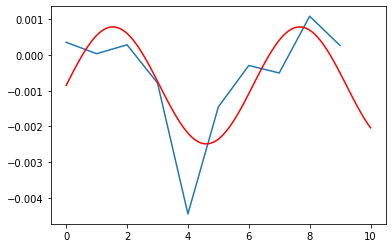

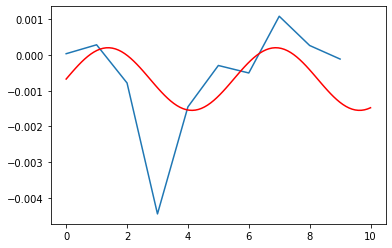

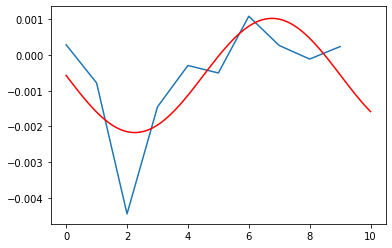

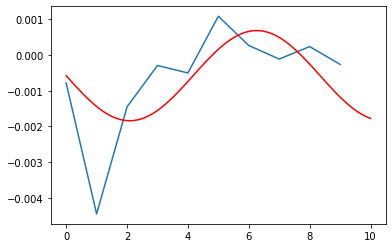

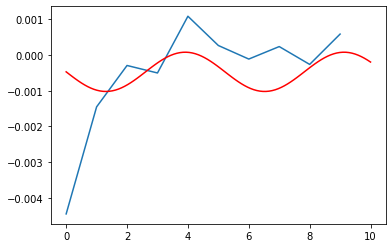

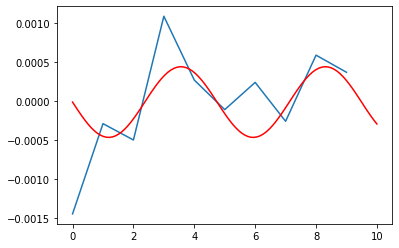

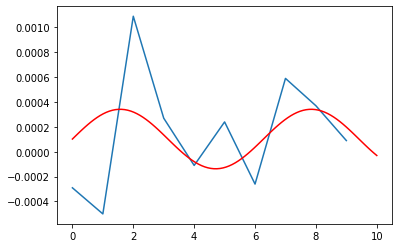

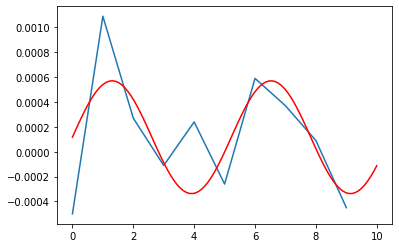

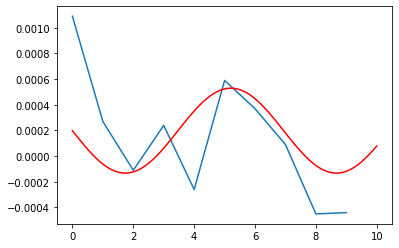

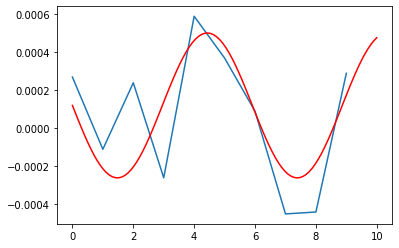

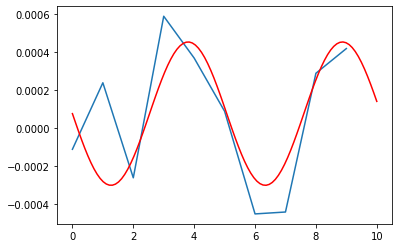

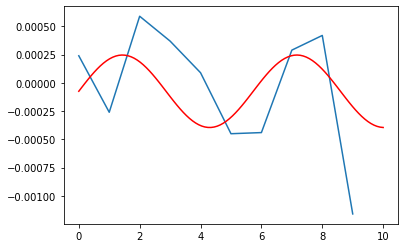

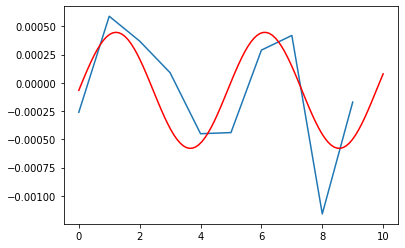

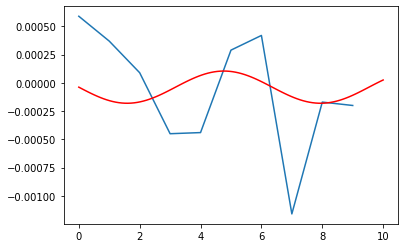

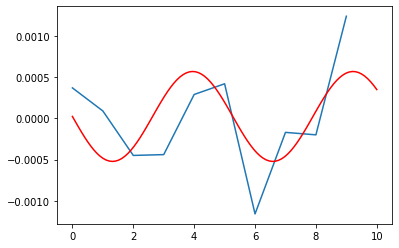

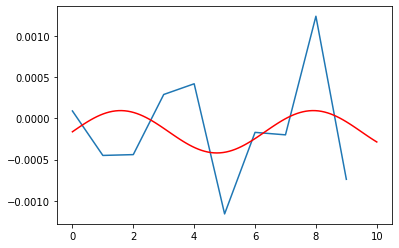

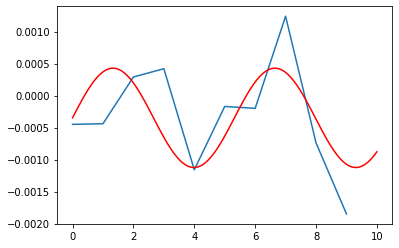

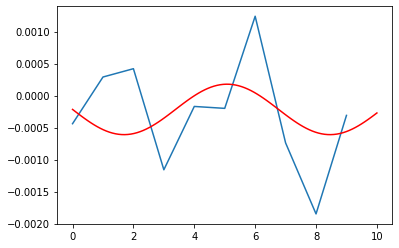

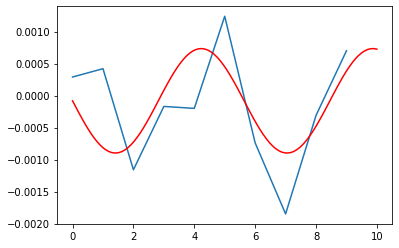

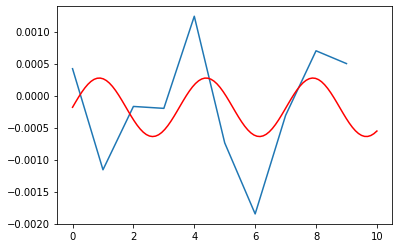

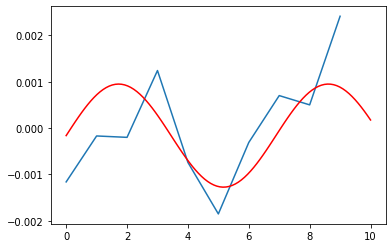

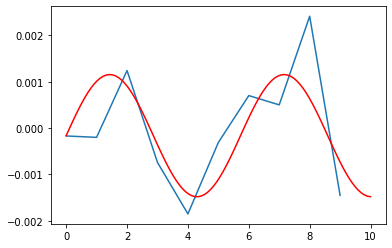

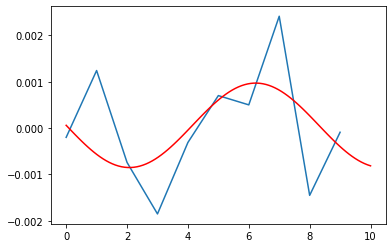

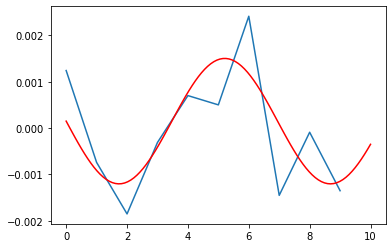

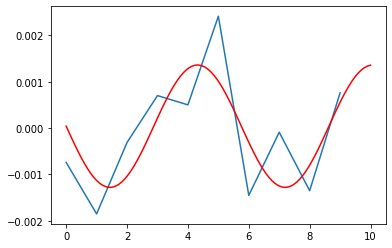

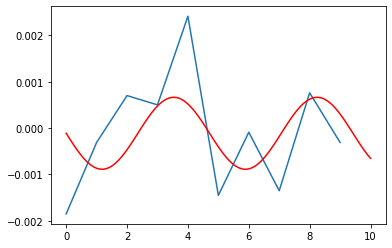

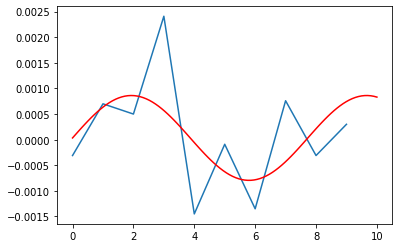

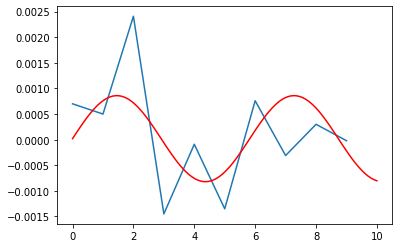

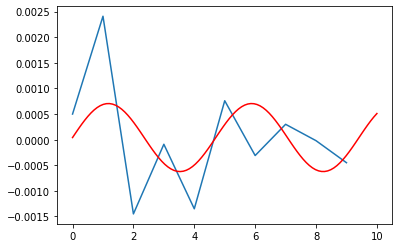

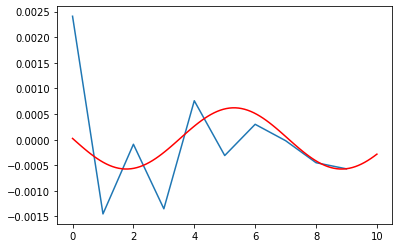

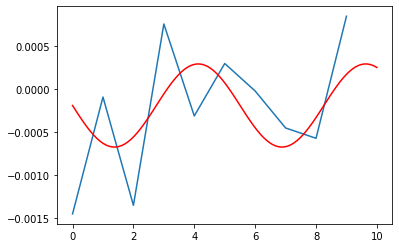

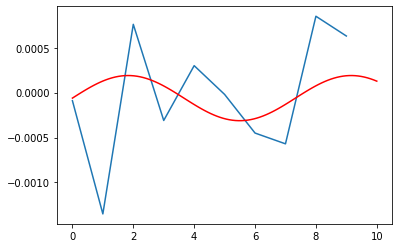

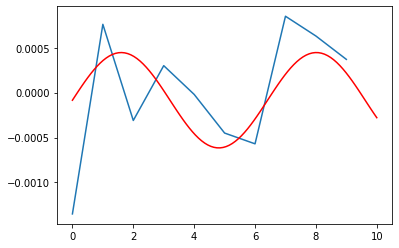

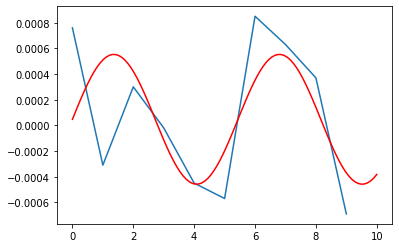

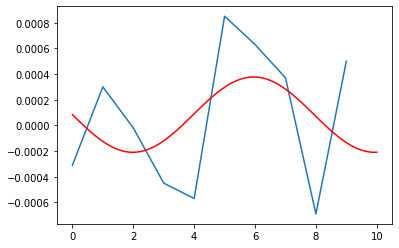

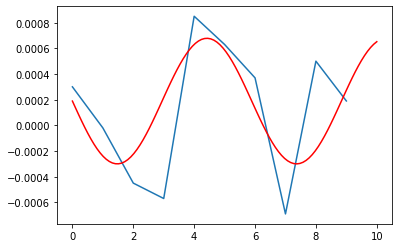

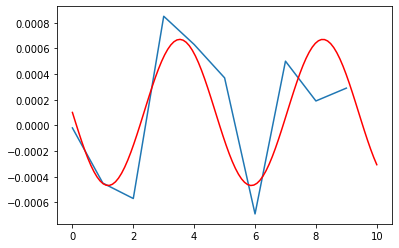

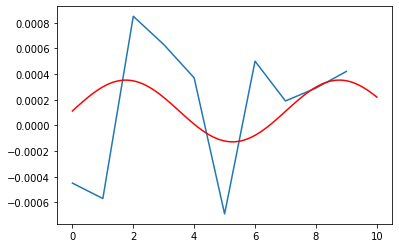

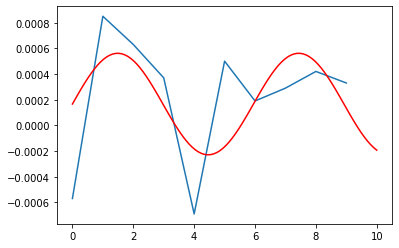

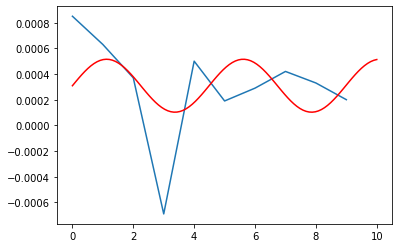

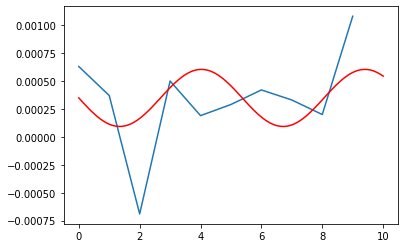

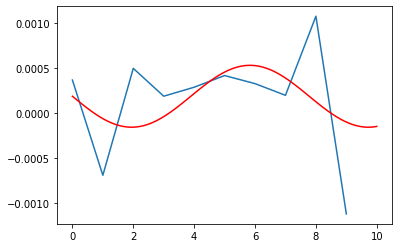

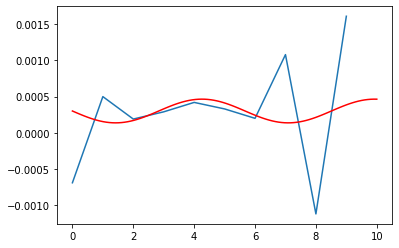

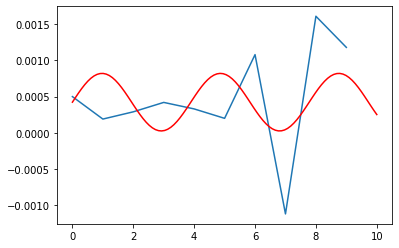

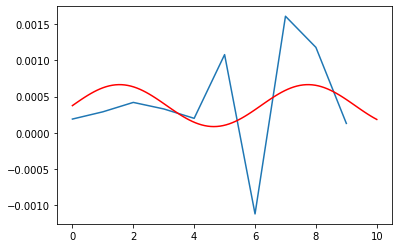

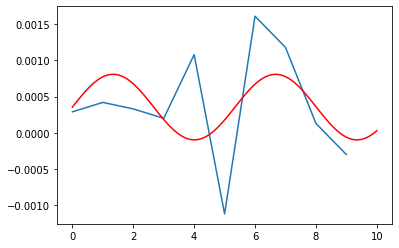

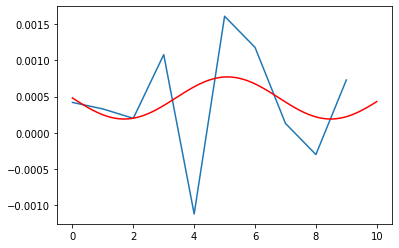

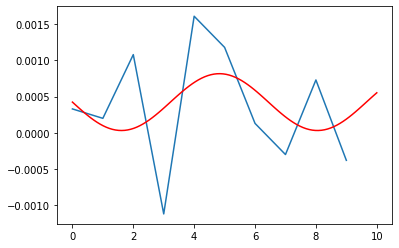

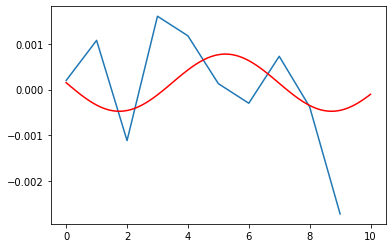

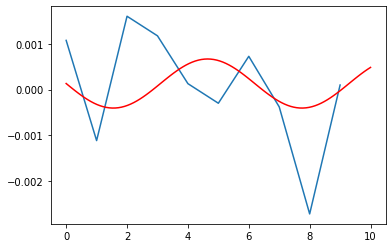

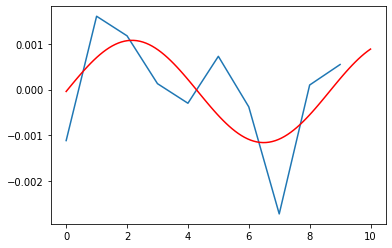

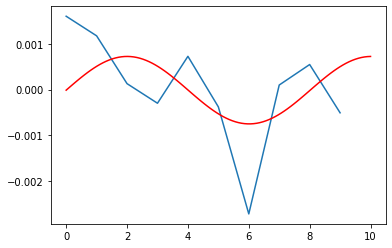

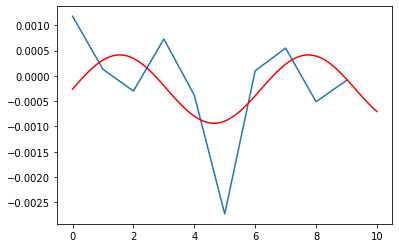

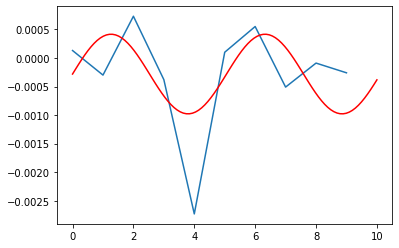

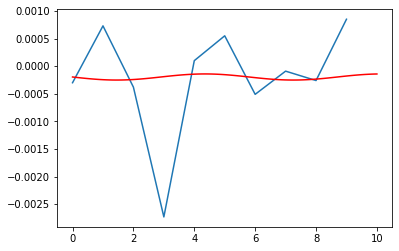

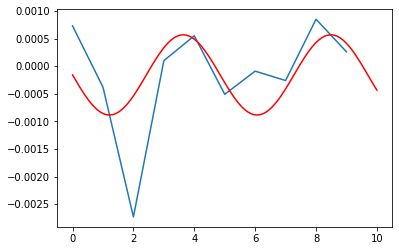

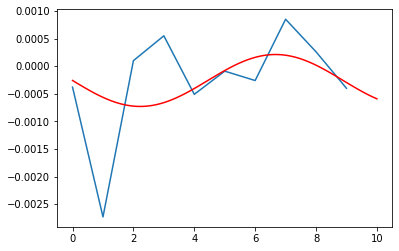

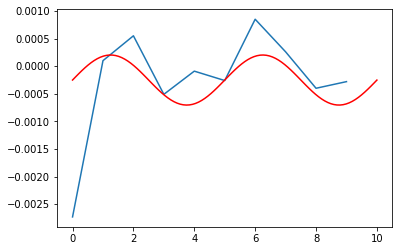

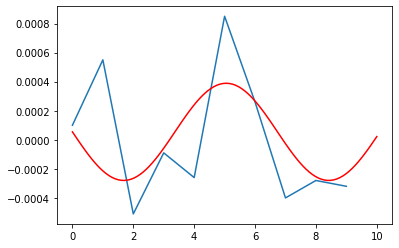

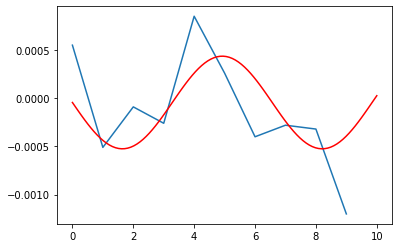

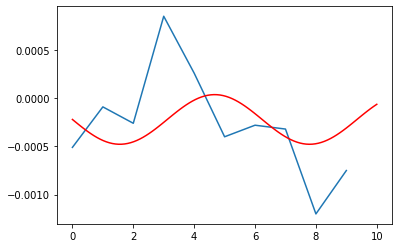

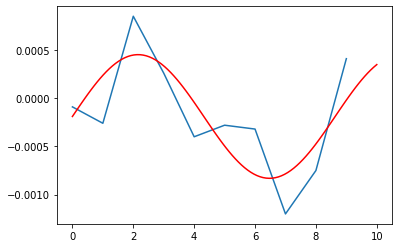

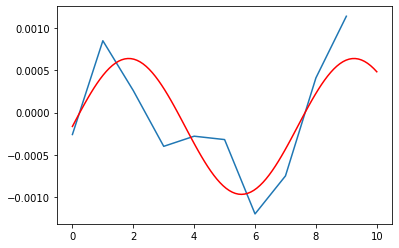

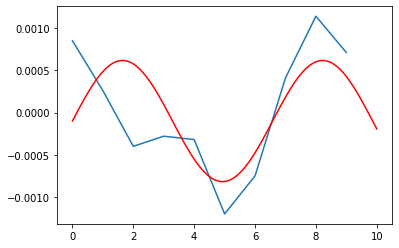

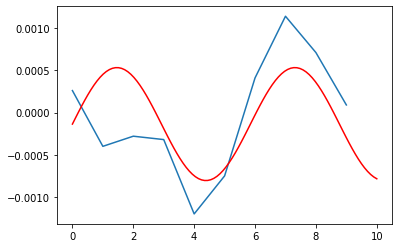

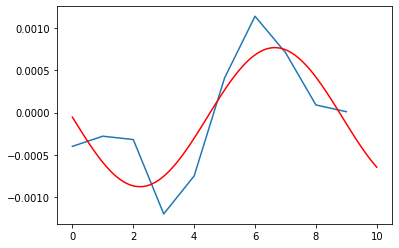

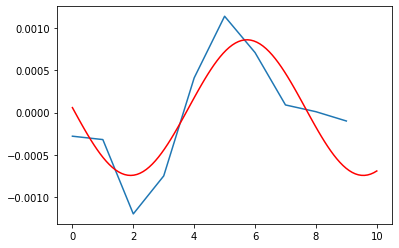

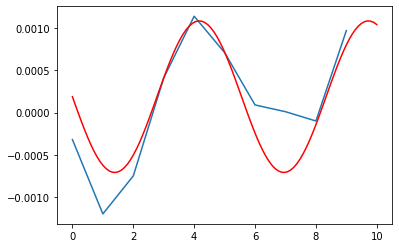

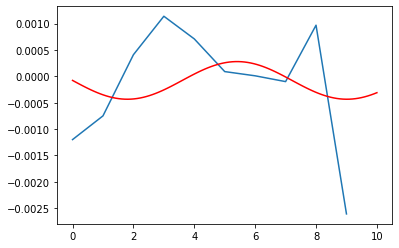

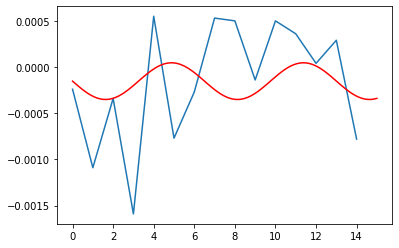

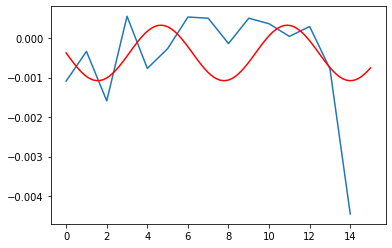

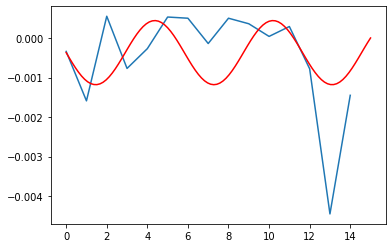

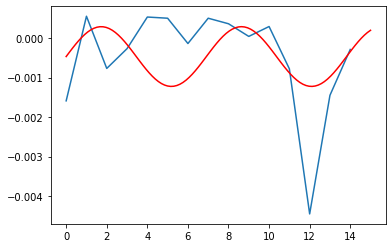

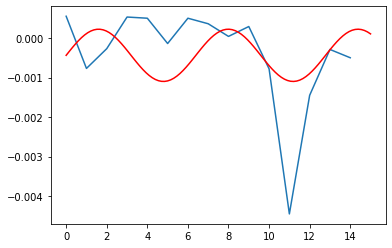

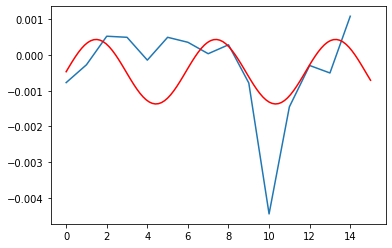

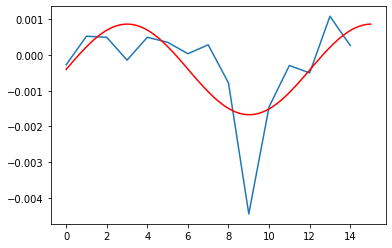

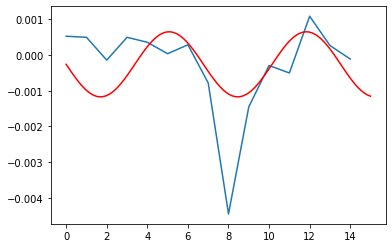

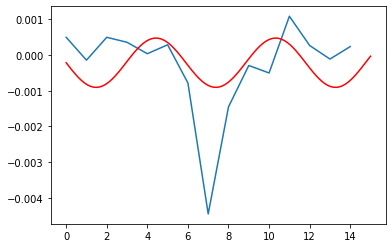

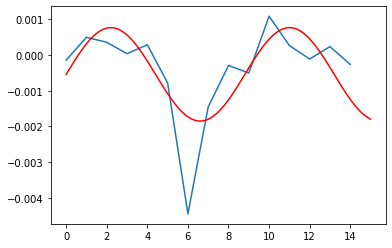

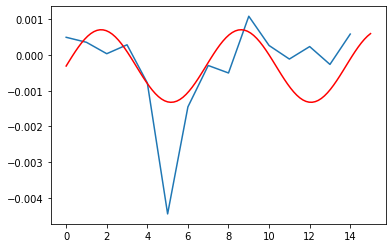

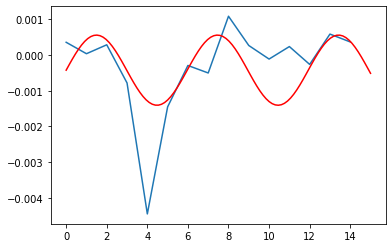

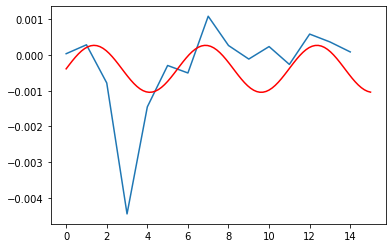

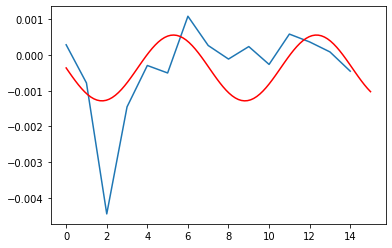

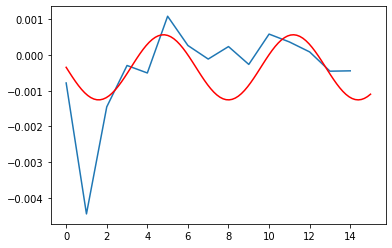

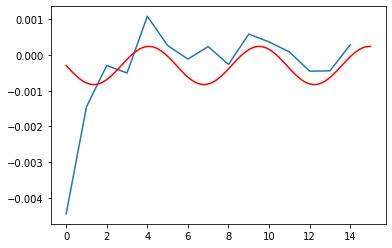

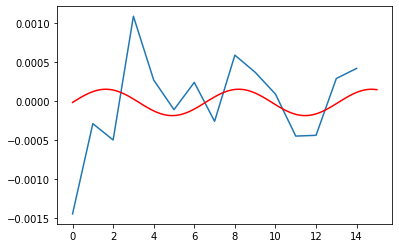

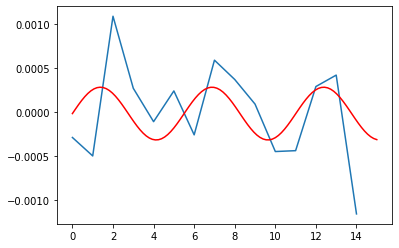

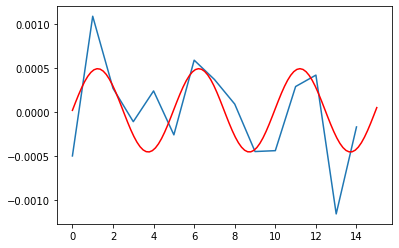

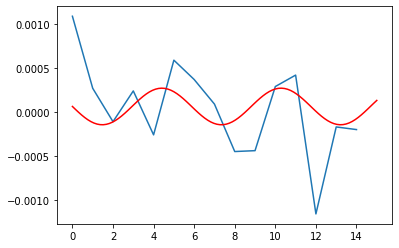

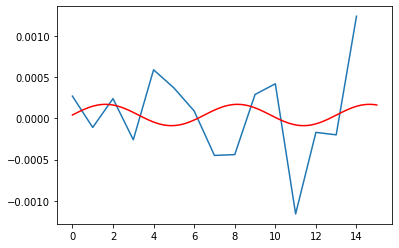

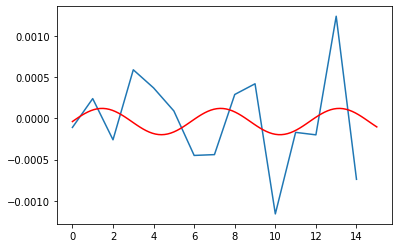

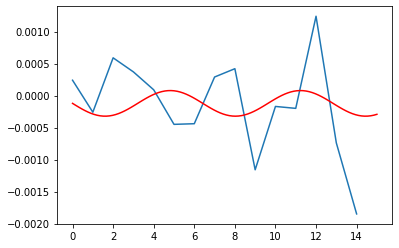

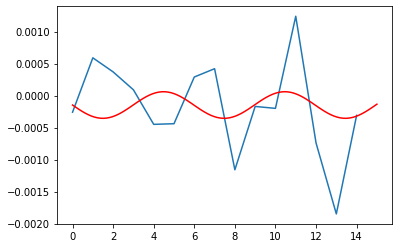

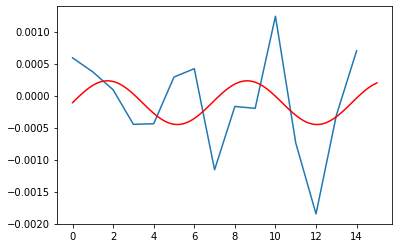

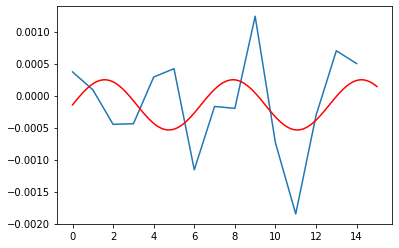

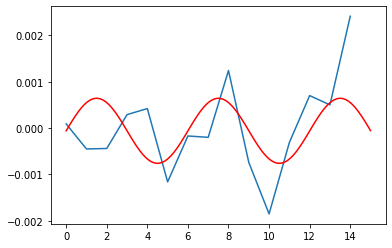

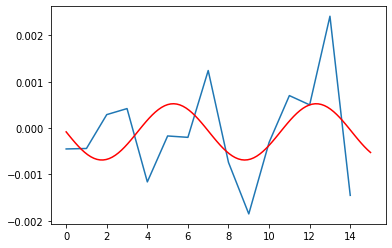

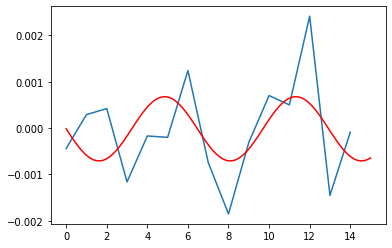

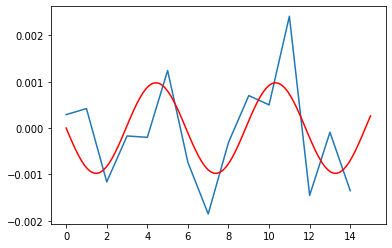

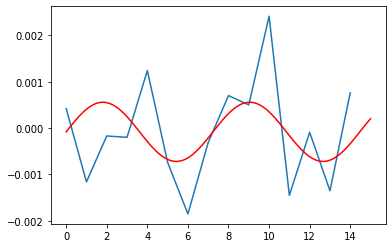

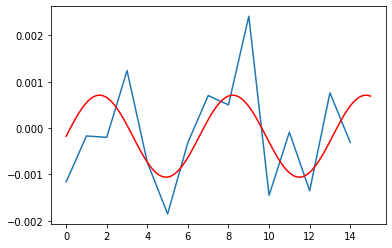

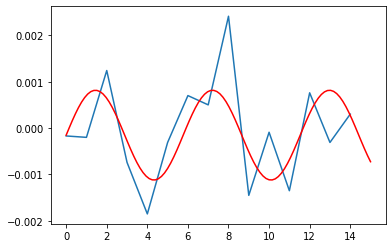

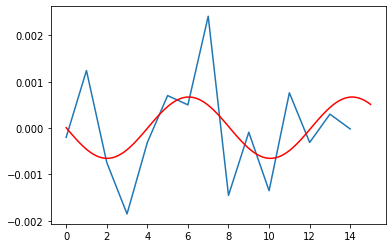

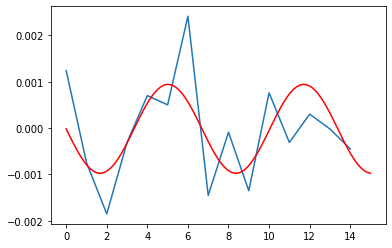

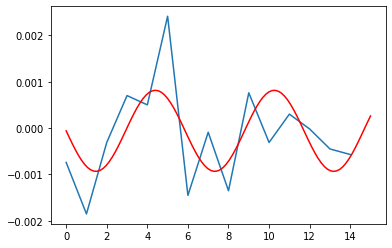

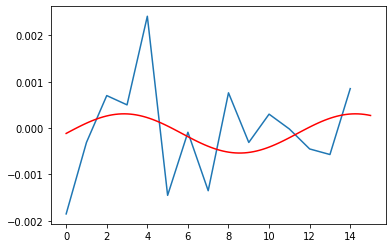

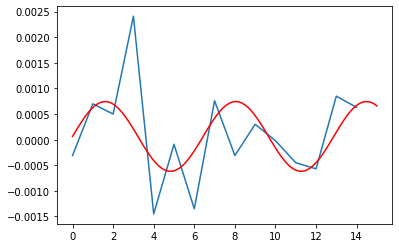

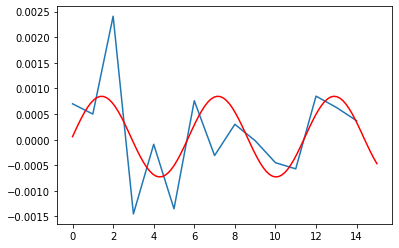

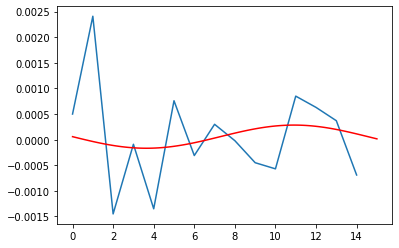

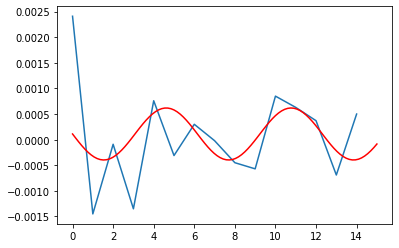

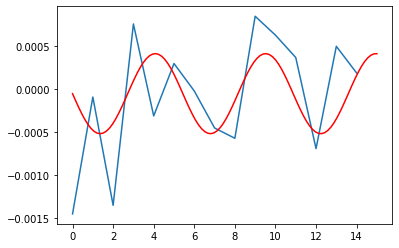

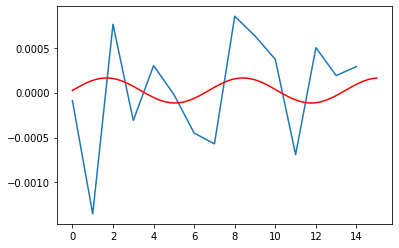

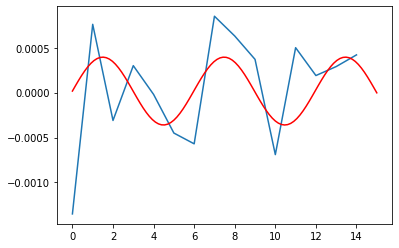

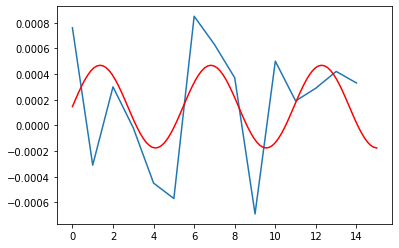

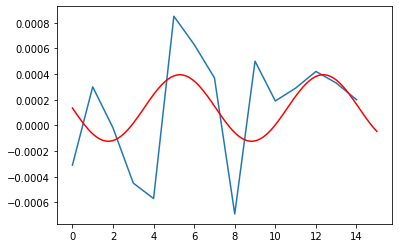

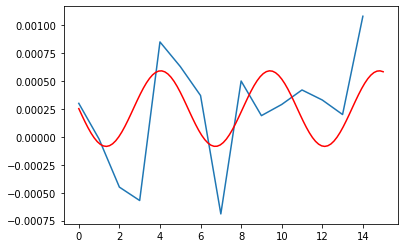

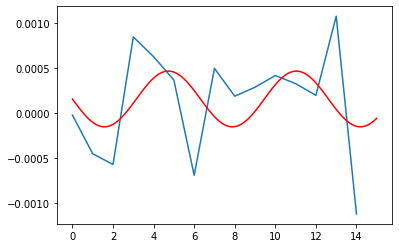

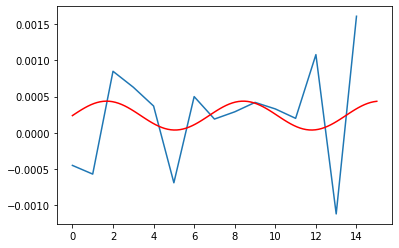

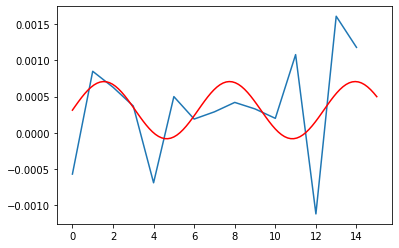

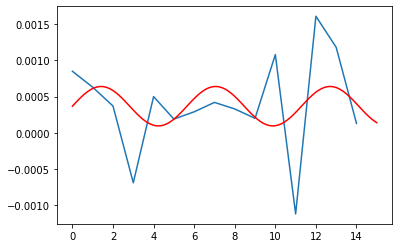

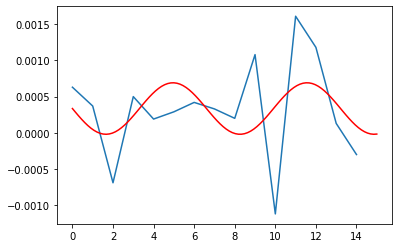

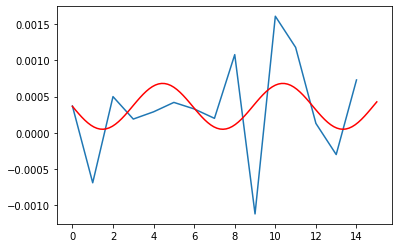

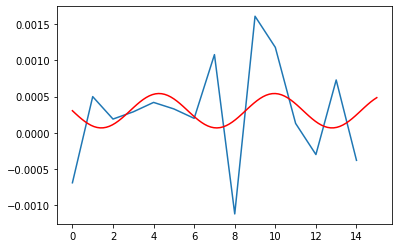

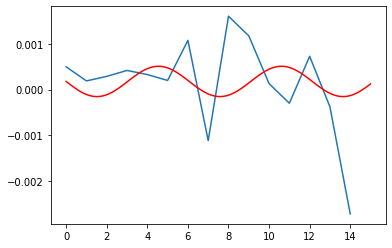

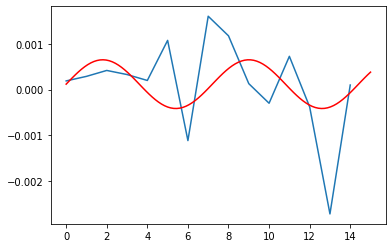

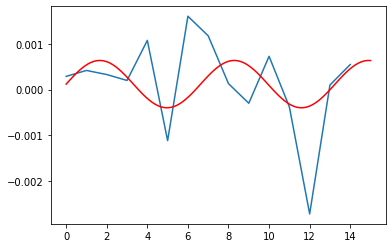

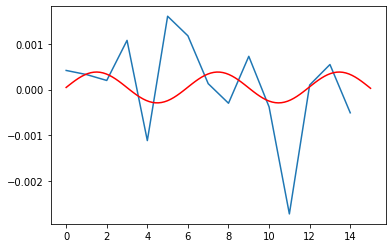

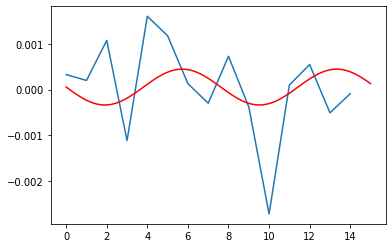

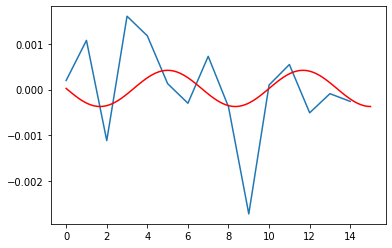

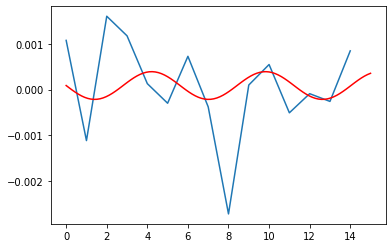

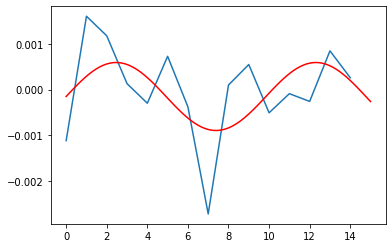

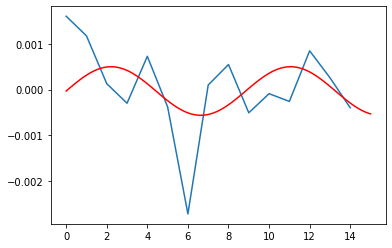

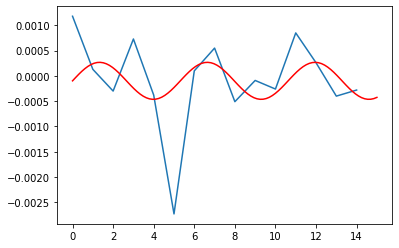

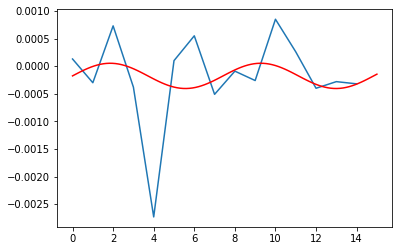

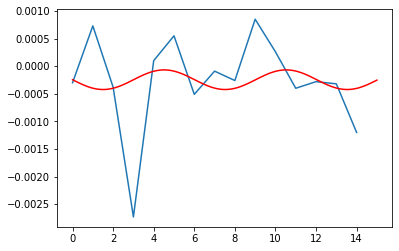

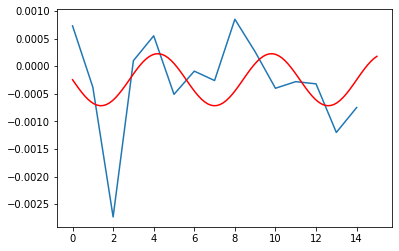

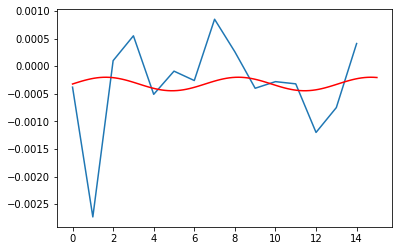

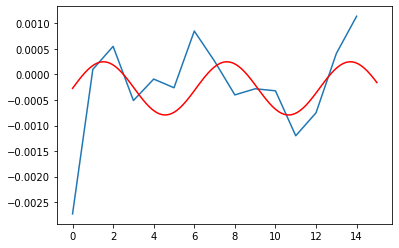

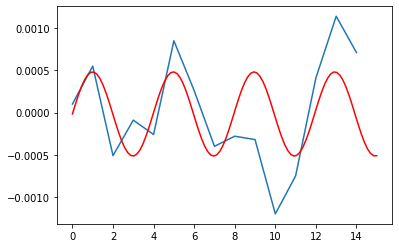

In [19]:
# (9) Get function data from Sine series function:
s = sine(train,[10,15],method='difference')

In [20]:
# Williams Accumulation Distribution Function
def wadl(prices,periods):
  """
  :param prices: dataframe of OHLC prices
  :param periods: (list) periods for which to calculate the function
  :return: williams accumulation distribution lines for each period
  """

  results = holder()
  dict = {}

  for i in range(0, len(periods)):
    WAD = [] # Williams Accumulated Distribution
    for j in range(periods[i], len(prices)-periods[i]):
      TRH = np.array([prices.high.iloc[j], prices.close.iloc[j-1]]).max() # True Range High
      TRL = np.array([prices.low.iloc[j], prices.close.iloc[j-1]]).min() # True Range Low

      if prices.close.iloc[j] > prices.close.iloc[j-1]:
        PM = prices.close.iloc[j] - TRL # PM -> Price Move
      elif prices.close.iloc[j] < prices.close.iloc[j-1]:
        PM = prices.close.iloc[j] - TRH 
      elif prices.close.iloc[j] == prices.close.iloc[j-1]:
        PM = 0
      else:
        print('Unknown error occured, see administator')

      AD = PM*prices.volume.iloc[j]  # Calculate Accumulated Distribution
      WAD = np.append(WAD, AD)

    WAD = WAD.cumsum()
    WAD = pd.DataFrame(WAD, index=prices.iloc[periods[i]:-periods[i]].index)
    WAD.columns = [['close']]

    dict[periods[i]] = WAD

  results.wadl = dict
  return results

In [21]:
# (8) Get function data from Williams accumulation distribution function:
results = wadl(train,[15])

line = results.wadl[15]

print(line)

                          close
date                           
2022-01-03 13:00:00  -10.018028
2022-01-03 14:00:00  -66.535897
2022-01-03 15:00:00  -98.671042
2022-01-03 16:00:00 -107.907137
2022-01-03 17:00:00 -111.421067
...                         ...
2022-01-06 06:00:00 -109.272012
2022-01-06 07:00:00 -112.405365
2022-01-06 08:00:00 -107.861427
2022-01-06 09:00:00 -100.106189
2022-01-06 10:00:00  -96.196533

[70 rows x 1 columns]
